In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [2]:
df = pd.read_csv('./data/ACS_estimates', skipinitialspace=True, low_memory = False)
df.head()

,label,borough,total_housing_units,occupied_housing_units,vacant_housing_units,1_room_units,2_room_units,3_room_units,4_room_units,5_room_units,...,unit_4_bedrooms,unit_5+_bedrooms,owner_occupied_units,renter_occupied_units,occupants_per_room_<=1,occupants_per_room_1-1.5,occupants_per_room_>=1.5,owned_median_value,rent_median_value,year
0,Estimate,BRONX,552421.0,533004.0,19417.0,41219.0,26963.0,146200.0,157613.0,105460.0,...,19330.0,8072.0,104431.0,428573.0,466688.0,34715.0,31601.0,465000.0,1313.0,2021.0
1,Estimate,BROOKLYN,1085993.0,1001868.0,84125.0,72187.0,86381.0,255228.0,290858.0,185074.0,...,64302.0,27479.0,303368.0,698500.0,897263.0,57711.0,46894.0,793300.0,1628.0,2021.0
2,Estimate,MANHATTAN,916609.0,737575.0,179034.0,114310.0,122583.0,257394.0,220249.0,111670.0,...,27708.0,5870.0,184279.0,553296.0,703553.0,16501.0,17521.0,940900.0,1866.0,2021.0
3,Estimate,QUEENS,902754.0,820686.0,82068.0,53573.0,51206.0,190825.0,212947.0,159559.0,...,57648.0,24105.0,374621.0,446065.0,737482.0,49332.0,33872.0,642000.0,1717.0,2021.0
4,Estimate,STATEN ISLAND,184154.0,170762.0,13392.0,5897.0,4178.0,21285.0,23682.0,35537.0,...,22695.0,7366.0,119237.0,51525.0,161096.0,6259.0,3407.0,605500.0,1442.0,2021.0


In [3]:
# FEATURE ENGINEERING
desired_cols = list(df.columns)
desired_cols.remove("label")
desired_cols.remove("borough")
df[desired_cols] = df[desired_cols].astype("int")
df = df.drop(columns=["label"]).sort_values("year")
df.head()

,borough,total_housing_units,occupied_housing_units,vacant_housing_units,1_room_units,2_room_units,3_room_units,4_room_units,5_room_units,6_room_units,...,unit_4_bedrooms,unit_5+_bedrooms,owner_occupied_units,renter_occupied_units,occupants_per_room_<=1,occupants_per_room_1-1.5,occupants_per_room_>=1.5,owned_median_value,rent_median_value,year
59,STATEN ISLAND,176696,163816,12880,3145,1881,20330,25117,33485,39302,...,23347,7280,114045,49771,157232,5186,1398,452300,1141,2010
55,BRONX,512024,471912,40112,24251,14502,155923,152272,96979,38867,...,18088,9718,88493,383419,413758,37160,20994,388900,974,2010
58,QUEENS,834965,772332,62633,32996,30863,168537,188746,176340,113793,...,58618,28220,338609,433723,703798,44723,23811,464800,1242,2010
57,MANHATTAN,846962,726090,120872,101223,111830,259565,215744,85654,38519,...,22131,7119,161647,564443,683146,23307,19637,825900,1305,2010
56,BROOKLYN,1000000,905317,94683,50285,44652,242503,280610,180657,95177,...,55736,34036,273500,631817,805170,66843,33304,566700,1079,2010


In [30]:
# HELPER FUNCTIONS 
# Get color palette based on delta value
def get_delta_colors(delta_list):
    return ["green" if i > 0.0 else "red" for i in delta_list]

# Set annotations for values on bar
def set_bar_annotations(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),\
        (p.get_x() + p.get_width() / 2,\
        p.get_height()), ha='center', va='center',\
        xytext=(0, 8),\
        textcoords='offset points')
        
# Gets yearly sorty data for any borough based on column `value`
def extract_yearly_sorted_data(df, boro, value):
    return df[df["borough"] == boro][[value, "year", "borough" ]].reset_index(drop=True)

# Compute yearly delta for any boro based on column `value`
def compute_delta(df, boro, value):
    data = extract_yearly_sorted_data(df, boro, value)
    data["delta"] = data[value].diff().replace(np.nan, 0).astype("int")
    return data.drop(columns=[value])

In [74]:
# Create delta df for all boros, must include NYC
def compute_nyc_delta(df):
    boros = df["borough"].unique()
    boros_delta = pd.DataFrame()
    for boro in boros:
        boros_delta = pd.concat([boros_delta, compute_delta(df, boro, "renter_occupied_units")])
    return boros_delta

In [75]:
boros_delta = compute_nyc_delta(df)

In [76]:
# Map chart for FacetGrid
def map_delta(data, color):
    chart = sns.barplot(x=data["year"], y=data["delta"], palette=get_delta_colors(data["delta"].to_list()))
    set_bar_annotations(chart.axes)
    chart.figure.set_size_inches((10,20))

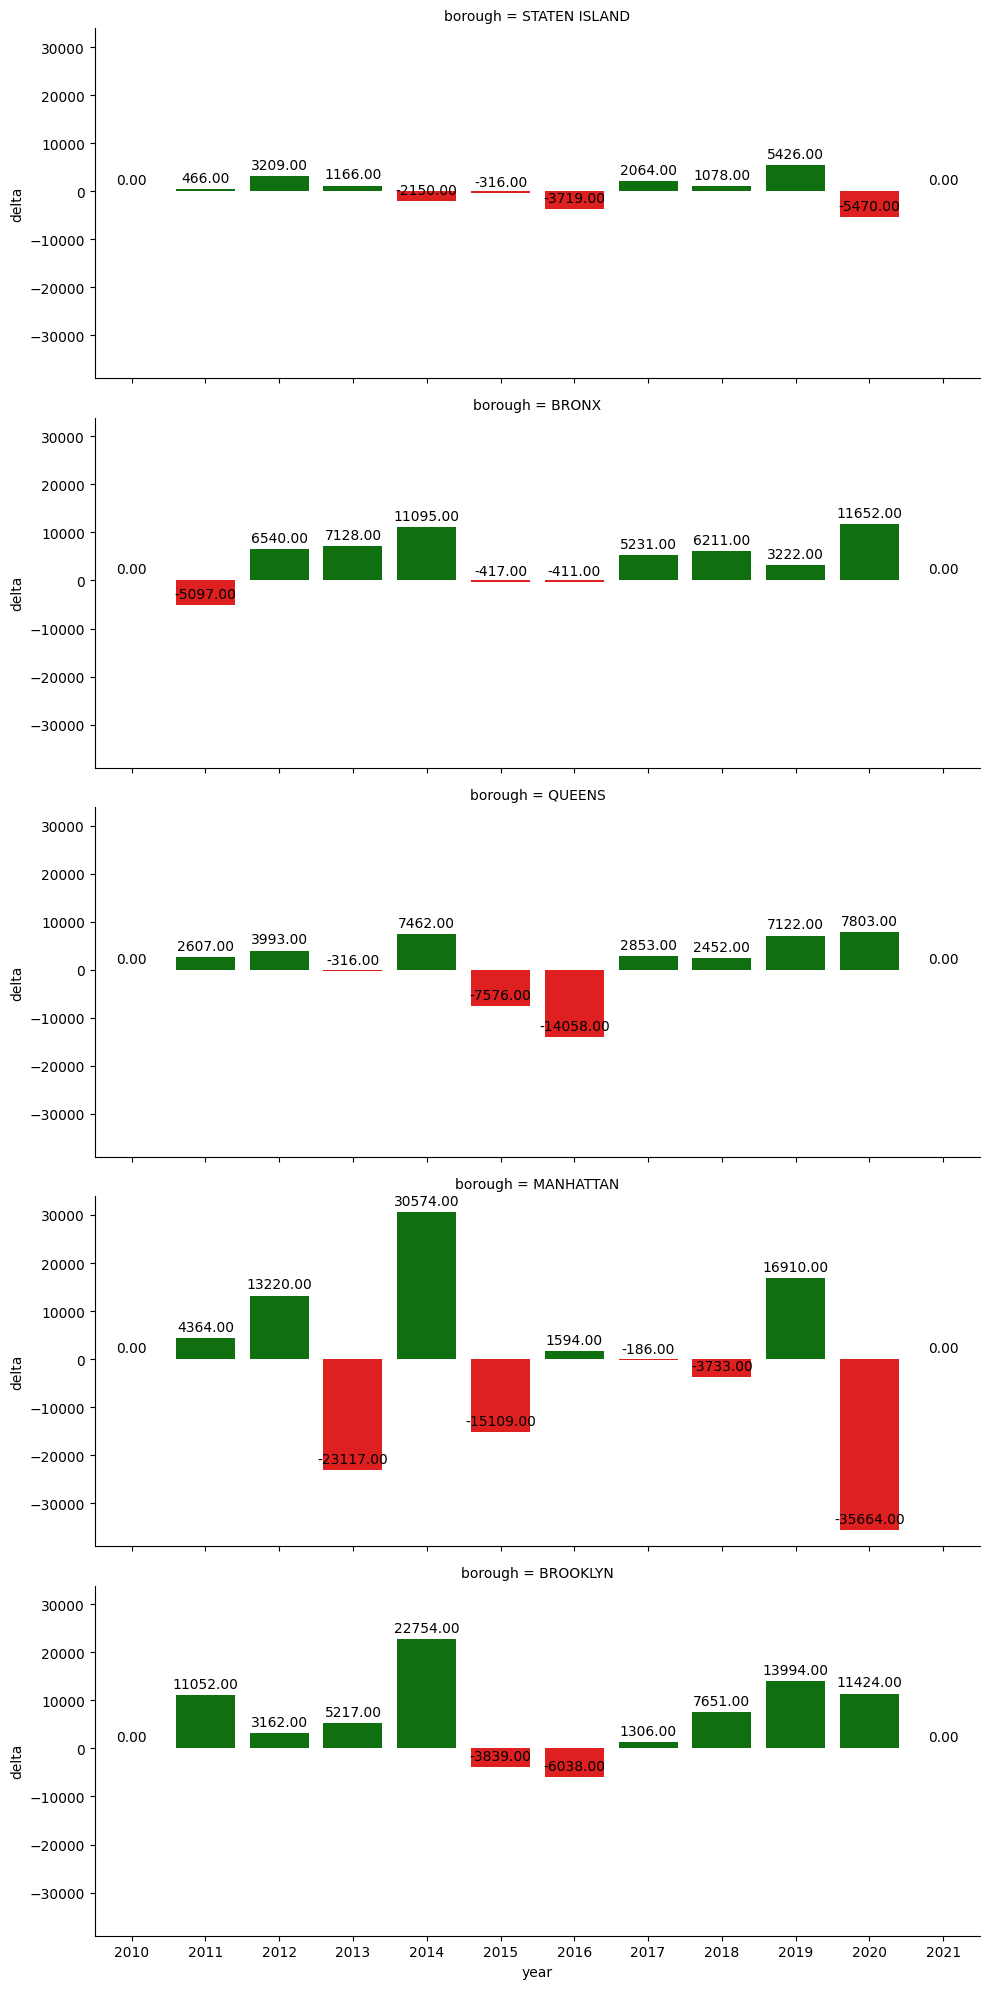

In [77]:
g = sns.FacetGrid(boros_delta, row="borough")
g.map_dataframe(map_delta)

In [19]:
# Get yearly NYC median data for column `value`
def get_nyc_data(df, value):
    nyc_data = df.groupby(["year"])[value].mean().to_frame().reset_index()
    nyc_data["borough"] = "NYC"
    return nyc_data

In [20]:
# Create comparison chart for all boros and NYC based on `value` column
def boro_comparison_line(df, value):
    data = df[["borough", "year", value]]
    nyc_data = get_nyc_data(df, value)
    data = pd.concat([data, nyc_data])
    chart = sns.lineplot(x="year", y=value, hue="borough", data=data)
    chart.axes.set_title(value.replace("_", " ").upper())

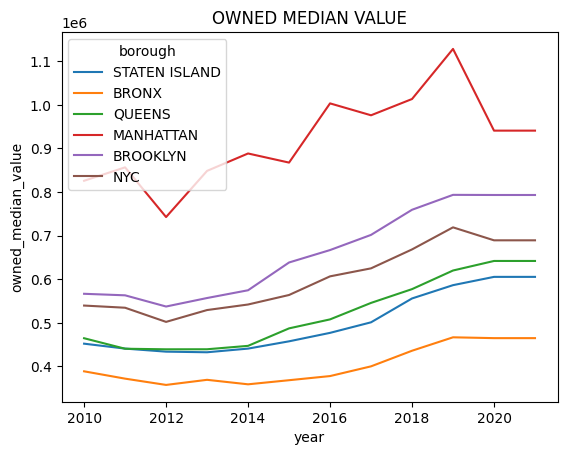

In [31]:
boro_comparison_line(df, "owned_median_value")

In [27]:
# Create `boro` yearly comparison for columns in `values`
def boro_comparison_bar(df, boro, values):
    comparison = ["year", "borough"] + values
    all_data = df[comparison]
    
    melted_data = pd.melt(all_data, id_vars=['borough', "year" ], value_vars=values)
    boro_data = melted_data[melted_data["borough"] == boro]
    
    graph = sns.barplot(data=boro_data, x="year", y="value", hue="variable", palette="dark", alpha=.6,)
    a = values[0].replace("_", " ").upper()
    b = values[1].replace("_", " ").upper()
    title = "{}: {} vs {}".format(boro, a, b)
    graph.axes.set_title(title)

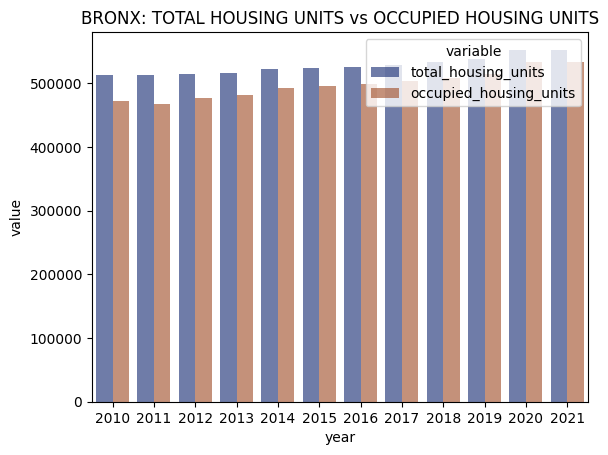

In [29]:
boro_comparison_bar(df, "BRONX", ["total_housing_units", "occupied_housing_units"])

In [56]:
bronx = df[df["borough"] == "BRONX"].pivot("year", "borough")

C:\Users\pumah\AppData\Local\Temp\ipykernel_21780\2071347977.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  bronx = df[df["borough"] == "BRONX"].pivot("year", "borough")


<AxesSubplot: xlabel='None-borough', ylabel='year'>

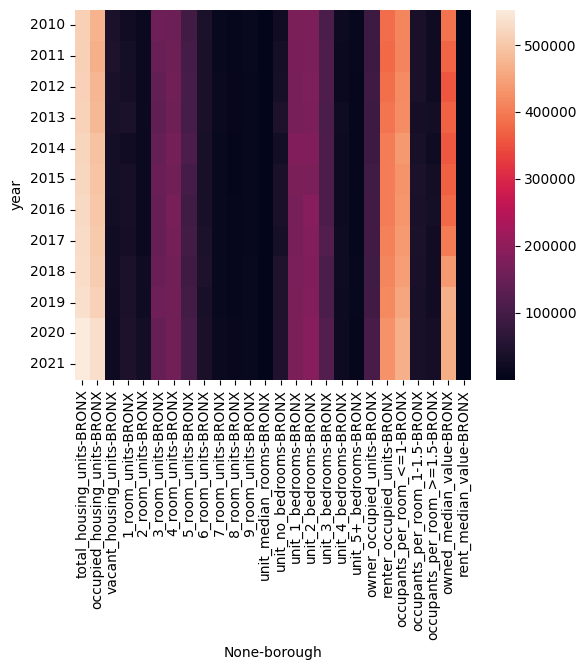

In [57]:
sns.heatmap(bronx)